https://www.kaggle.com/viridisquotient/arimax

In [2]:
import data_prep_helper
import statsmodels.api as sm
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import matplotlib.pyplot as plt

In [307]:
do = data_prep_helper.ChartData()

In [50]:
do.apply_boll_bands("bitcoin_hist", append_chart=True)

In [308]:
corr_df = do.chart_df


In [309]:
corr_df = corr_df.resample('D').interpolate()

In [296]:
corr_df = corr_df.diff().dropna()

In [363]:
#creating the train and validation set
train = corr_df[:int(0.8*(len(corr_df)))]
valid = corr_df[int(0.8*(len(corr_df))):]

In [364]:
months = train.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = train.index

In [365]:
train['bitcoin_Price_prev_week'] = train['bitcoin_Price'].shift(8)
train['bitcoin_Price_prev_month'] = train['bitcoin_Price'].shift(31)
train['alibaba_Price_prev_month'] = train['alibaba_Price'].shift(31)
train['alibaba_Price_prev_week'] = train['alibaba_Price'].shift(8)
train['amazon_Price_prev_month'] = train['amazon_Price'].shift(31)
train['googl_Price_prev_month'] = train['googl_Price'].shift(31)
train['googl_Price_prev_week'] = train['googl_Price'].shift(8)

train['bitcoin_trends_prev_month'] = train['bitcoin_Google_Trends'].shift(31)
train['bitcoin_trends_prev_week'] = train['bitcoin_Google_Trends'].shift(8)
train['cryptocurrency_trends_prev_month'] = train['cryptocurrency_Google_Trends'].shift(31)
train['cryptocurrency_trends_prev_week'] = train['cryptocurrency_Google_Trends'].shift(8)
train['economy_pos_prev_month'] = train['economy_pos_sents'].shift(31)


train.fillna(0, inplace=True)
 
train = pd.concat([train, dummy_months.iloc[:,:3]], axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [366]:
train

,bitcoin_Price,sp500_Price,dax_Price,googl_Price,gold_Price,alibaba_Price,amazon_Price,bitcoin_Google_Trends,cryptocurrency_Google_Trends,trading_Google_Trends,...,googl_Price_prev_month,googl_Price_prev_week,bitcoin_trends_prev_month,bitcoin_trends_prev_week,cryptocurrency_trends_prev_month,cryptocurrency_trends_prev_week,economy_pos_prev_month,month-1,month-2,month-3
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-08,282.700000,2062.140000,9837.610000,506.910000,10.810000,105.030000,300.46,442.000000,1.000000,1676.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,1,0,0
2015-01-09,288.000000,2044.810000,9648.500000,500.720000,10.990000,103.020000,296.93,456.000000,0.000000,1632.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,1,0,0
2015-01-10,281.766667,2039.293333,9692.966667,499.500000,11.103333,102.553333,295.09,433.666667,1.666667,1596.666667,...,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,1,0,0
2015-01-11,275.533333,2033.776667,9737.433333,498.280000,11.216667,102.086667,293.25,411.333333,3.333333,1561.333333,...,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,1,0,0
2015-01-12,269.300000,2028.260000,9781.900000,497.060000,11.330000,101.620000,291.41,389.000000,5.000000,1526.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-22,3965.200000,2792.670000,11457.700000,1116.560000,13.040000,176.920000,1631.56,1538.000000,145.000000,1886.000000,...,1078.630000,1129.20,1412.000000,1338.0,139.000000,155.00,0.113315,0,1,0
2019-02-23,3921.366667,2793.816667,11473.596667,1116.816667,12.896667,179.030000,1632.04,1565.333333,148.333333,1908.666667,...,1084.410000,1119.63,1388.000000,1237.0,136.000000,150.00,0.147692,0,1,0
2019-02-24,3877.533333,2794.963333,11489.493333,1117.073333,12.753333,181.140000,1632.52,1592.666667,151.666667,1931.333333,...,1084.000000,1121.35,1466.000000,1343.5,148.000000,155.75,0.101274,0,1,0


In [331]:
months = valid.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = valid.index



valid['bitcoin_Price_prev_week'] = valid['bitcoin_Price'].shift(8)
valid['bitcoin_Price_prev_month'] = valid['bitcoin_Price'].shift(31)
valid['alibaba_Price_prev_month'] = valid['alibaba_Price'].shift(31)
valid['alibaba_Price_prev_week'] = valid['alibaba_Price'].shift(8)
valid['amazon_Price_prev_month'] = valid['amazon_Price'].shift(31)
valid['googl_Price_prev_month'] = valid['googl_Price'].shift(31)
valid['googl_Price_prev_week'] = valid['googl_Price'].shift(8)

valid['bitcoin_trends_prev_month'] = valid['bitcoin_Google_Trends'].shift(31)
valid['bitcoin_trends_prev_week'] = valid['bitcoin_Google_Trends'].shift(8)
valid['cryptocurrency_trends_prev_month'] = valid['cryptocurrency_Google_Trends'].shift(31)
valid['cryptocurrency_trends_prev_week'] = valid['cryptocurrency_Google_Trends'].shift(8)
valid['economy_pos_prev_month'] = valid['economy_pos_sents'].shift(31)


valid = pd.concat([valid, dummy_months], axis=1)

#train.dropna(inplace=True)
#valid.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [332]:
%%time
s1i1 = train['bitcoin_Price']
exog_s1i1 = train[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   #'alibaba_Price_prev_month',
                   #'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2',
                   ]].fillna(0)
    

arimax = sm.tsa.statespace.SARIMAX(s1i1, exog=exog_s1i1,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D').fit()
print(arimax.summary())

                               SARIMAX Results                                
Dep. Variable:          bitcoin_Price   No. Observations:                 1511
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -10338.946
Date:                Wed, 01 Apr 2020   AIC                          20701.893
Time:                        17:04:03   BIC                          20765.731
Sample:                    01-08-2015   HQIC                         20725.667
                         - 02-26-2019                                         
Covariance Type:                  opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
bitcoin_Price_prev_week              0.0520      0.020      2.580      0.010       0.012       0.091
bitcoin_Price_prev_month            -0.0399      0.028     -1.423

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



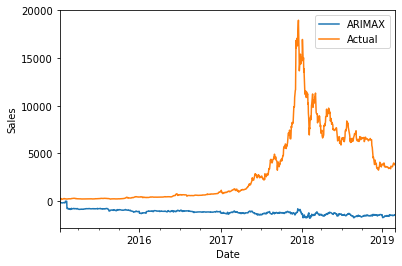

In [333]:


exog = train[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   #'alibaba_Price_prev_month',
                   #'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)
forecast =  arimax.predict( dynamic=True, exog=exog)
actual = train["bitcoin_Price"]

forecast.plot()
actual.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');



In [334]:
exog = valid[[
                   'bitcoin_Price_prev_week',
                   'bitcoin_Price_prev_month',
                   'alibaba_Price_prev_week',
                   #'alibaba_Price_prev_month',
                   #'amazon_Price_prev_month',
                   'googl_Price_prev_month',
                   'bitcoin_trends_prev_week',
                   'bitcoin_trends_prev_month',
                   'cryptocurrency_trends_prev_week',
                   'cryptocurrency_trends_prev_month',
                   'month-1', 'month-2'
                   ]].fillna(0)

In [335]:
forecast = arimax.get_forecast(steps=len(valid), exog=exog)

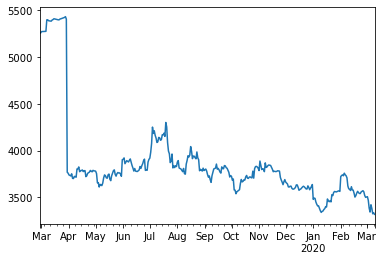

In [336]:
forecast.predicted_mean.plot()
#valid["bitcoin_Price"].plot()

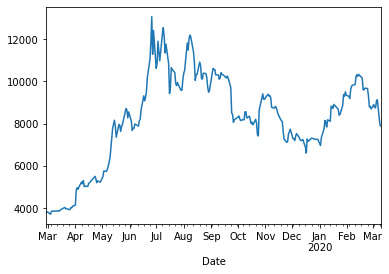

In [337]:
valid["bitcoin_Price"].plot()

In [338]:
sqrt(mean_squared_error(forecast.predicted_mean, valid["bitcoin_Price"]))

4981.2072043243525

In [339]:
var_forecast = pd.read_csv("var_pred.csv")

In [342]:
test = var_forecast["bitcoin_Price"] + forecast.predicted_mean


In [344]:
forecast.predicted_mean

2019-02-27    5257.893395
2019-02-28    5258.446700
2019-03-01    5273.761003
2019-03-02    5274.314424
2019-03-03    5274.867904
                 ...     
2020-03-06    3420.786593
2020-03-07    3382.361381
2020-03-08    3324.443316
2020-03-09    3335.801182
2020-03-10    3318.686180
Freq: D, Length: 378, dtype: float64

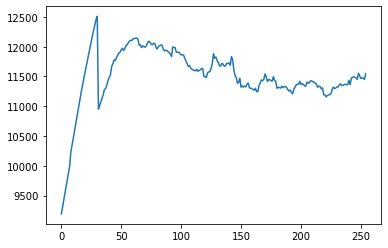

In [350]:
plt.plot(var_forecast["bitcoin_Price"].values + forecast.predicted_mean[:255].values)

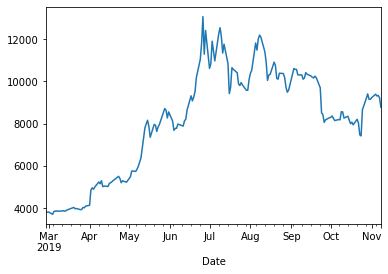

In [352]:
valid['bitcoin_Price'][:255].plot()

In [353]:
sqrt(mean_squared_error((var_forecast["bitcoin_Price"].values + forecast.predicted_mean[:255].values), valid["bitcoin_Price"][:255]))

4174.072373632708